In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam

In [15]:
# Load and preprocess data
def load_data(file_path):
    # Load the data from the CSV file, treating "error" as a missing value indicator and keeping the header as None
    data = pd.read_csv(file_path, header=None, na_values="error", dtype=str)
    
    # Convert all numeric columns to float, coercing non-numeric values to NaN
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    # Extract labels (first column) and features (all other columns) as NumPy arrays
    labels = data.iloc[:, 0].values
    features = data.iloc[:, 1:].values
    
    # Return the features and labels
    return features, labels

def preprocess_data(features, labels):
    # Impute missing values with the mean of the respective column
    imputer = SimpleImputer(strategy='mean')
    features = imputer.fit_transform(features)
    
    # Scale the features using StandardScaler to have mean = 0 and standard deviation = 1
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Return the preprocessed features and the original labels
    return features, labels

In [7]:
# Wrapper class to adapt Keras model to scikit-learn
class KerasModelWrapper():
    def __init__(self, keras_model):
        # Initialize the KerasModelWrapper instance with the provided Keras model
        self.model = keras_model

    def predict(self, X):
        # Use the Keras model to make predictions on the input data (X),
        # apply a threshold of 0.5 to convert probabilities to class labels,
        # and then flatten the result into a 1D array
        return (self.model.predict(X) > 0.5).astype('int32').flatten()

    def predict_proba(self, X):
        # Use the Keras model to predict probabilities for the input data (X),
        # and stack the predicted probabilities for the negative class (1 - predicted probability)
        # with the predicted probabilities for the positive class
        return np.hstack([1 - self.model.predict(X), self.model.predict(X)])

def create_model(learning_rate=0.001, dropout_rate=0.2, n_hidden_layers=3, n_units_per_layer=128):
    # Create a new Sequential model
    model = keras.Sequential()
    
    # Add the input layer with 256 units, ReLU activation, and an input shape of 28
    model.add(keras.layers.Dense(256, activation='relu', input_shape=(28,)))
    
    # Add batch normalization to the model for regularization and faster training
    model.add(BatchNormalization())
    
    # Add a dropout layer to prevent overfitting
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Add a specified number of hidden layers, each with specified number of units, ReLU activation,
    # batch normalization, and dropout for regularization
    for _ in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_units_per_layer, activation='relu'))
        model.add(BatchNormalization())
        model.add(keras.layers.Dropout(dropout_rate))
    
    # Add the output layer with a single unit and sigmoid activation for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Define the learning rate schedule, which decays exponentially over time
    lr_schedule = ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=1000, decay_rate=0.9)
    
    # Create the Adam optimizer with the learning rate schedule
    optimizer = Adam(learning_rate=lr_schedule)
    
    # Compile the model with the optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Return the compiled model
    return model

def plot_roc_curve(y_true, y_pred_probs, title='ROC Curve'):
    # Compute false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Create a new matplotlib figure
    plt.figure()
    
    # Plot the ROC curve with the AUC score
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    
    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Set axis limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Set the title of the plot and position of the legend
    plt.title(title)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

def plot_roc_curve(y_true, y_pred_probs, title='ROC Curve'):
    # Compute false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Create a new matplotlib figure
    plt.figure()
    
    # Plot the ROC curve with the AUC score
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    
    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Set axis limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Set the title of the plot and position of the legend
    plt.title(title)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

def custom_plot_confusion_matrix(y_true, y_pred, cmap='Blues'):
    # Compute the confusion matrix using the true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a new matplotlib figure
    plt.figure()
    
    # Create a heatmap of the confusion matrix using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False)
    
    # Set axis labels and plot title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")
    
    # Display the plot
    plt.show()

In [50]:
# Load and preprocess data
features, labels = load_data('HIGGS_train.csv')
features, labels = preprocess_data(features, labels)

In [51]:
# Prepare k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

In [52]:
# Wrap the model for use with scikit-learn
wrapped_model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=256, verbose=0)

<ipython-input-52-6833fce4ba39>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  wrapped_model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=256, verbose=0)


In [53]:
# Define a search space for hyperparameters
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.1, 0.2, 0.3],
    'n_hidden_layers': [2, 3, 4],
    'n_units_per_layer': [64, 128, 256]
}

In [54]:
# Perform the hyperparameter search using GridSearchCV
grid = GridSearchCV(estimator=wrapped_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(features, labels)

In [55]:
# Show the results of the search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Extract the best hyperparameters from the grid search result
best_params = grid_result.best_params_
learning_rate_opt = best_params['learning_rate']
dropout_rate_opt = best_params['dropout_rate']
n_hidden_layers_opt = best_params['n_hidden_layers']
n_units_per_layer_opt = best_params['n_units_per_layer']

Best: 0.755152 using {'dropout_rate': 0.1, 'learning_rate': 0.01, 'n_hidden_layers': 3, 'n_units_per_layer': 256}


3750/3750 [==============================] - 8s 2ms/step


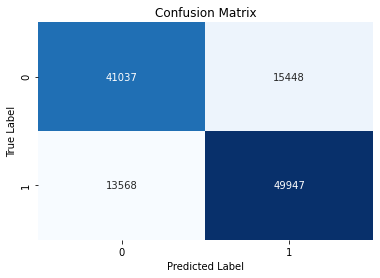

Accuracy: 0.7582
Validation Accuracy: 0.7581999897956848
ROC AUC Score: 0.8422911430800726

3750/3750 [==============================] - 8s 2ms/step


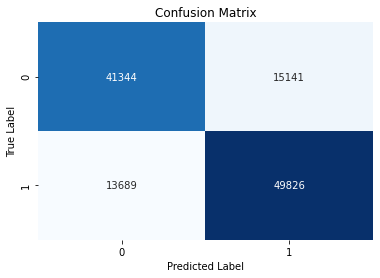

Accuracy: 0.75975
Validation Accuracy: 0.7597249746322632
ROC AUC Score: 0.8435604404284982

3750/3750 [==============================] - 8s 2ms/step


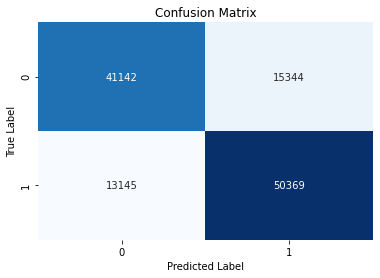

Accuracy: 0.7625916666666667
Validation Accuracy: 0.7625916600227356
ROC AUC Score: 0.8473388939558305

3750/3750 [==============================] - 8s 2ms/step


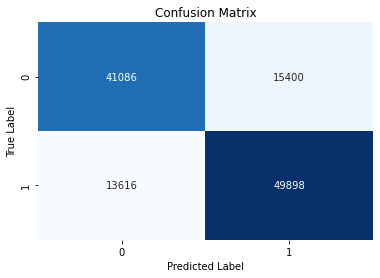

Accuracy: 0.7582
Validation Accuracy: 0.7581999897956848
ROC AUC Score: 0.8418830987534709

3750/3750 [==============================] - 8s 2ms/step


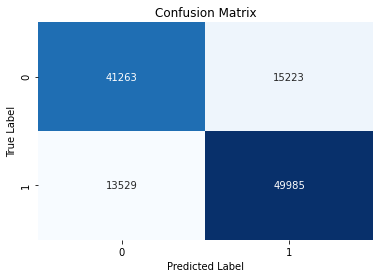

Accuracy: 0.7604
Validation Accuracy: 0.7603999972343445
ROC AUC Score: 0.8448279636894216



In [161]:
# Train the model using k-fold cross-validation with the best hyperparameters
validation_scores = []
val_accuracy_scores = []
roc_auc_scores = []

# Define an early stopping callback with criteria for stopping, restoring the best weights,
# and monitoring validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

# Create a StratifiedKFold cross-validator with 5 splits to ensure that each fold has the same
# proportion of samples from each class as the complete dataset
skf = StratifiedKFold(n_splits=5)

for train_index, val_index in skf.split(features, labels):
    X_train, X_val = features[train_index], features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create a ReduceLROnPlateau callback
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    model = create_model(learning_rate=learning_rate_opt, dropout_rate=dropout_rate_opt, n_hidden_layers=n_hidden_layers_opt, n_units_per_layer=n_units_per_layer_opt)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=256, verbose=0, callbacks=[early_stop, reduce_lr_callback])

    # Wrap the Keras model with KerasModelWrapper
    wrapped_model = KerasModelWrapper(model)

    # Make predictions on the validation dataset
    y_pred_probs = wrapped_model.predict_proba(X_val)[:, 1]
    y_pred = wrapped_model.predict(X_val)

    # Calculate the accuracy
    acc = accuracy_score(y_val, y_pred)
    validation_scores.append(acc)

    # Compute the confusion matrix using the custom function
    custom_plot_confusion_matrix(y_val, y_pred)

    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_pred_probs)
    roc_auc_scores.append(roc_auc)

    # Calculate the validation accuracy
    val_acc = history.history['val_accuracy'][-1]
    val_accuracy_scores.append(val_acc)

    print("Accuracy:", acc)
    print("Validation Accuracy:", val_acc)
    print("ROC AUC Score:", roc_auc)
    print()

In [162]:
# Compute average scores across all folds
average_accuracy = np.mean(validation_scores)
average_val_accuracy = np.mean(val_accuracy_scores)  
average_roc_auc = np.mean(roc_auc_scores)

print("Average Accuracy:", average_accuracy)
print("Average Validation Accuracy:", average_val_accuracy)  
print("Average ROC AUC Score:", average_roc_auc)

Average Accuracy: 0.7598283333333333
Average Validation Accuracy: 0.7598233222961426
Average ROC AUC Score: 0.8439803079814588


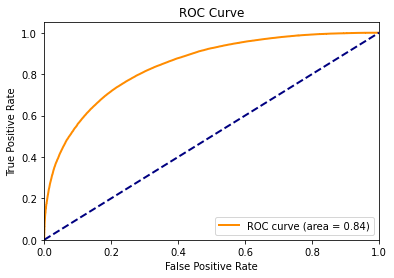

In [163]:
# Plot the ROC curve for the last fold
plot_roc_curve(y_val, y_pred_probs)

In [164]:
# save as .h5
model.save('rizzlers_model.h5')